In [319]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import dbfread
import community
import networkx as nx
import matplotlib.pyplot as plt
import pysal

cwd = os.getcwd()
datapath = os.path.join(os.path.dirname(cwd), 'data')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
datapath

'/Users/macbook/Google Drive/0408-CaliVote/data'

In [3]:
def getdata(filename):
    return os.path.join(datapath, filename)

## Getting data:  
note that 06067 is the FIPS code for Sacramento County

In [4]:
# precinct shapefile
pre_shp = gpd.read_file(os.path.join(getdata('mprec_state_g12_v01_shp'), 
                                        'mprec_state_g12_v01.shp'))
pre_shp_sa = pre_shp[pre_shp['FIPS'] == '06067']
print pre_shp_sa.shape

# census tract geojson for sacramento
ct = gpd.read_file(getdata('sacramento_tracks.geojson'))
cb = gpd.read_file(getdata('SacramentoCensusBlock.geojson'))

# historical voting info
his_sacramento = gpd.read_file(os.path.join(getdata('067-sacramento-county'), 'SacCounty_PREC_2016_11_GENERAL.shp'))
votes = pd.read_csv(getdata('067-sacramento.csv'))

# income and voting population csv file
ivp = pd.read_csv(getdata('Income_and_Voting_Population_2015.csv'))

(1848, 10)


## Locate each precinct area into census blocks:  
use data: cb, pre_shp_sa (both shapefiles)

In [101]:
print 'census tract shape:'
print ct.shape
print 'census blocks shape:'
print cb_sa.shape
print 'precinct shape:'
print pre_shp_sa.shape

census tract shape:
(317, 11)
census blocks shape:
(912, 11)
precinct shape:
(1848, 10)


## Spatial index each precinct area on census tract level:

In [6]:
gdf = pre_shp_sa

In [7]:
# using R-Tree algorithm
spatial_index = gdf.sindex
precise_matches = {}
for i, geoid in enumerate(ct.GEOID):
    possible_matches_index = list(spatial_index.intersection(ct.geometry[i].bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    precise_matches[geoid] = possible_matches[possible_matches.intersects((ct.geometry[i]))]

### Precise_matches gives precinct areas in a given Census Tract  
In the example below, '06067002500' is the GEOID of a Census Tract

In [14]:
ct_geoid = '06067002500'
precise_matches[ct_geoid].head()

,AREA,COUNTY,DB_ID,ELECTION,FIPS,ID,MPREC,PRECINCT_K,TYPE,geometry
69038,0.080323,67,69039,g12,06067,13486536,0044336,060670044336,mprec,"POLYGON ((-121.481676 38.553818, -121.481583 3..."
69031,0.093958,67,69032,g12,06067,13486406,0044318,060670044318,mprec,"POLYGON ((-121.488267 38.552542, -121.488236 3..."
69020,0.063591,67,69021,g12,06067,13486193,0044216,060670044216,mprec,"POLYGON ((-121.488267 38.552542, -121.488405 3..."
69557,0.035796,67,69558,g12,06067,13425897,0044620,060670044620,mprec,"POLYGON ((-121.483222 38.531226, -121.483222 3..."
69028,0.031823,67,69029,g12,06067,13486346,0045102,060670045102,mprec,"POLYGON ((-121.484242 38.539394, -121.484323 3..."


### Take a look at the eligibal voter population information in Sacramento:

In [16]:
sum_pop = ivp.sum(0)

print 'voting population'
print sum_pop[5]
print 'white and black voting population'
print sum([sum_pop[8], sum_pop[11]])
print 'other minority groups voting population'
print sum([sum_pop[14], sum_pop[17], sum_pop[20], sum_pop[23], sum_pop[26]])
print '[white + black voting population] / [other race groups voting population]'
print sum([sum_pop[8], sum_pop[11]])/sum([sum_pop[14], sum_pop[17], sum_pop[20], sum_pop[23], sum_pop[26]])

voting population
1105088
white and black voting population
774712.772819
other minority groups voting population
330375.227181
[white + black voting population] / [other race groups voting population]
2.34494813497


### As for  (E-10 to E-4), there should be : 1 vote center per every 50,000 registered voters which calculates to:

In [17]:
print sum_pop[4]/50000
print 'voting centers in total'

29
voting centers in total


### Taking population by race into account:

In [18]:
d = pysal.weights.Rook.from_dataframe(ct)
edge_list = []

for i in d.neighbors.keys():
    for j in d.neighbors.get(i):
        edge_list.append((i,j))

In [153]:
# we want a weighted edgelist
# weight defined by similarity in voting population density

# calculate population density in census tract
ct['voting_pop_density'] = ct['Voting Population']/ct.geometry.area

def pop_density_similarities(pair):
    ''' given CT pair index,
    find the similarities in population density between them
    defined by: voting_pop_density[small]/voting_pop_density[big]
    '''
    a, b = pair
    c,d = ct.loc[a,'voting_pop_density'] , ct.loc[b,'voting_pop_density']
    return (a, b, 1.000 * min(c,d)/max(c,d))


In [154]:
edge_list_w = copy(edge_list)
edge_list_w = map(pop_density_similarities, edge_list_w)

In [157]:
# create graph
G = nx.Graph()
G.add_nodes_from(ct.index)
G.add_weighted_edges_from(edge_list_w)

In [289]:
% run /Users/macbook/Downloads/python-louvain-0.3/community/__init__.py
partition = best_partition(G)

In [267]:
weight = map(lambda x: x[2], edge_list_w)

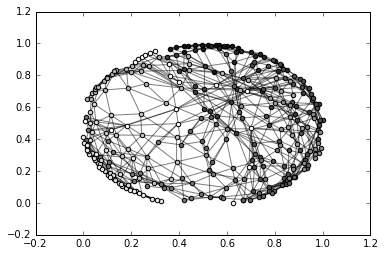

In [298]:
size = float(len(set(partition.values())))
pos = nx.spring_layout(G,weight = 'Weight')
count = 0.

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size), axis= 'off')


nx.draw_networkx_edges(G,pos, alpha=0.5, axis= 'off')
plt.show()

In [318]:
print count

13.0
